In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.0001
# train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure", 0.2, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh-pitched-10", 0.2, 16)

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-28 23:47:29.260482: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-28 23:47:29.260511: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-28 23:47:29.260519: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-28 23:47:29.260550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 23:47:29.260568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [2]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

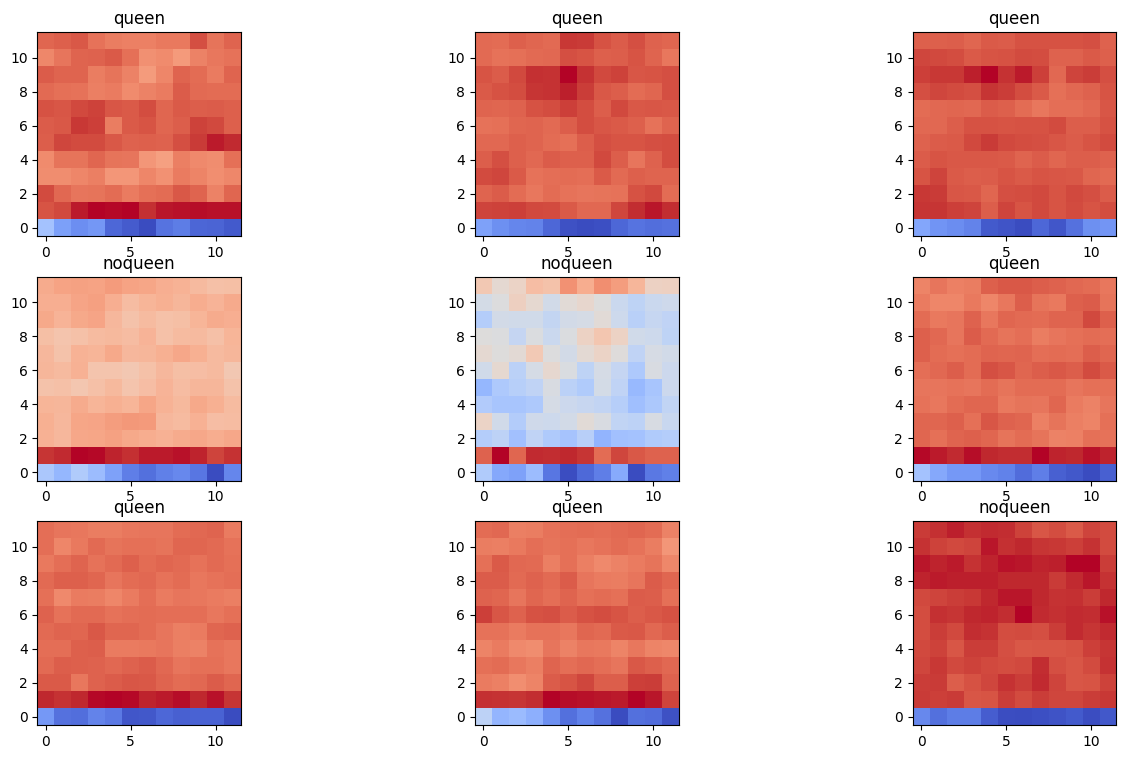

In [3]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [5]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

2024-03-28 23:47:30.734486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-28 23:47:31.451891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


43/43 [==============================] - 1s 19ms/step - loss: 0.6581 - accuracy: 0.6336 - val_loss: 0.6246 - val_accuracy: 0.6140
Epoch 2/20
43/43 [==============================] - 0s 10ms/step - loss: 0.5885 - accuracy: 0.6453 - val_loss: 0.5783 - val_accuracy: 0.6316
Epoch 3/20
43/43 [==============================] - 0s 11ms/step - loss: 0.5263 - accuracy: 0.7124 - val_loss: 0.5263 - val_accuracy: 0.7310
Epoch 4/20
43/43 [==============================] - 0s 11ms/step - loss: 0.4761 - accuracy: 0.7839 - val_loss: 0.4937 - val_accuracy: 0.7251
Epoch 5/20
43/43 [==============================] - 0s 11ms/step - loss: 0.4328 - accuracy: 0.8146 - val_loss: 0.4438 - val_accuracy: 0.8012
Epoch 6/20
43/43 [==============================] - 0s 10ms/step - loss: 0.3867 - accuracy: 0.8350 - val_loss: 0.4246 - val_accuracy: 0.8187
Epoch 7/20
43/43 [==============================] - 0s 10ms/step - loss: 0.3398 - accuracy: 0.8745 - val_loss: 0.3918 - val_accuracy: 0.8421
Epoch 8/20
43/43 [======

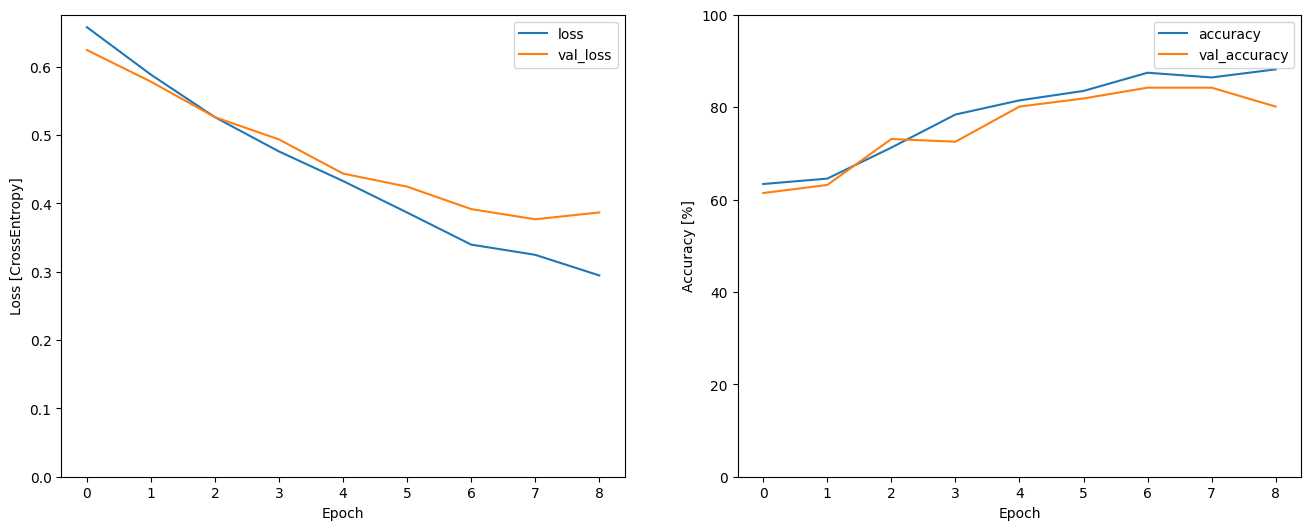

In [6]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
43/43 [==============================] - 1s 9ms/step - loss: 0.6908 - accuracy: 0.5971 - val_loss: 0.6531 - val_accuracy: 0.6140
Epoch 2/20
43/43 [==============================] - 0s 6ms/step - loss: 0.6254 - accuracy: 0.6307 - val_loss: 0.6199 - val_accuracy: 0.6433
Epoch 3/20
43/43 [==============================] - 0s 5ms/step - loss: 0.5912 - accuracy: 0.6876 - val_loss: 0.5928 - val_accuracy: 0.7018
Epoch 4/20
43/43 [==============================] - 0s 6ms/step - loss: 0.5575 - accuracy: 0.7299 - val_loss: 0.5684 - val_accuracy: 0.7368
Epoch 5/20
43/43 [==============================] - 0s 6ms/step - loss: 0.5295 - accuracy: 0.7635 - val_loss: 0.5352 - val_accuracy: 0.7661
Epoch 6/20
43/43 [==============================] - 0s 5ms/step - loss: 0.5070 - accuracy: 0.7810 - val_loss: 0.5136 - val_accuracy: 0.7778
Epoch 7/20
43/43 [==============================] - 0s 6ms/step - loss: 0.4850 - accuracy: 0.7956 - val_loss: 0.5016 - val_accuracy: 0.7661
Epoch 8/20
43/43 [==

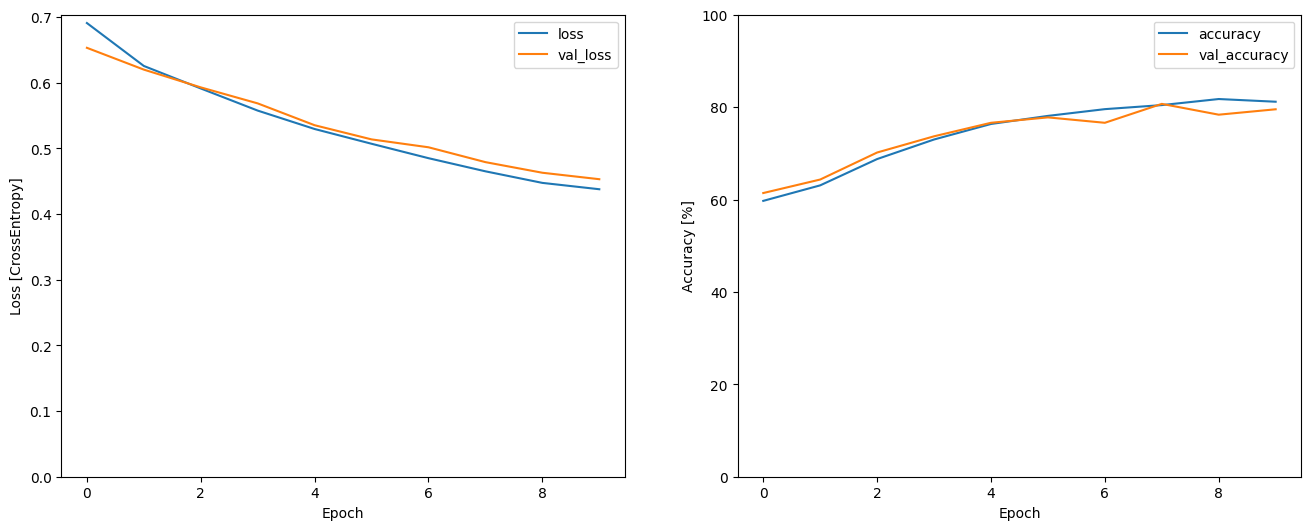

In [7]:
model_mfcc_conv = get_conv_model(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


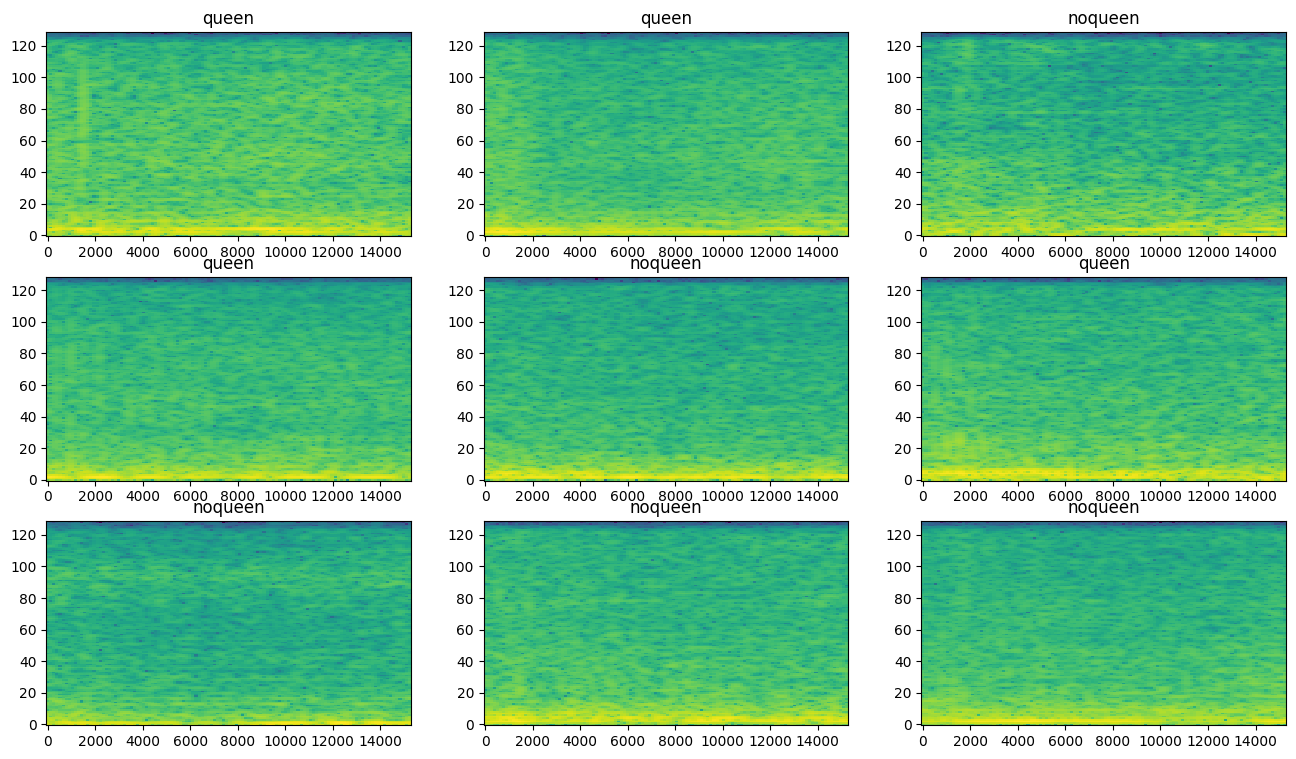

In [8]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [9]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/20
43/43 [==============================] - 1s 16ms/step - loss: 0.6426 - accuracy: 0.5562 - val_loss: 0.6355 - val_accuracy: 0.6140
Epoch 2/20
43/43 [==============================] - 0s 10ms/step - loss: 0.6052 - accuracy: 0.6029 - val_loss: 0.6120 - val_accuracy: 0.6199
Epoch 3/20
43/43 [==============================] - 0s 10ms/step - loss: 0.5814 - accuracy: 0.6715 - val_loss: 0.5852 - val_accuracy: 0.7953
Epoch 4/20
43/43 [==============================] - 0s 10ms/step - loss: 0.5356 - accuracy: 0.7168 - val_loss: 0.5412 - val_accuracy: 0.6901
Epoch 5/20
43/43 [==============================] - 0s 10ms/step - loss: 0.4976 - accuracy: 0.7708 - val_loss: 0.5450 - val_accuracy: 0.7719
Epoch 6/20
43/43 [==============================] - 0s 10ms/step - loss: 0.4592 - accuracy: 0.7912 - val_loss: 0.5100 - val_accuracy: 0.7778
Epoch 7/20
43/43 [==============================] - 0s 10ms/step - loss: 0.4044 - accuracy: 0.8350 - val_loss: 0.4869 - val_accuracy: 0.7953
Epoch 8/20
43

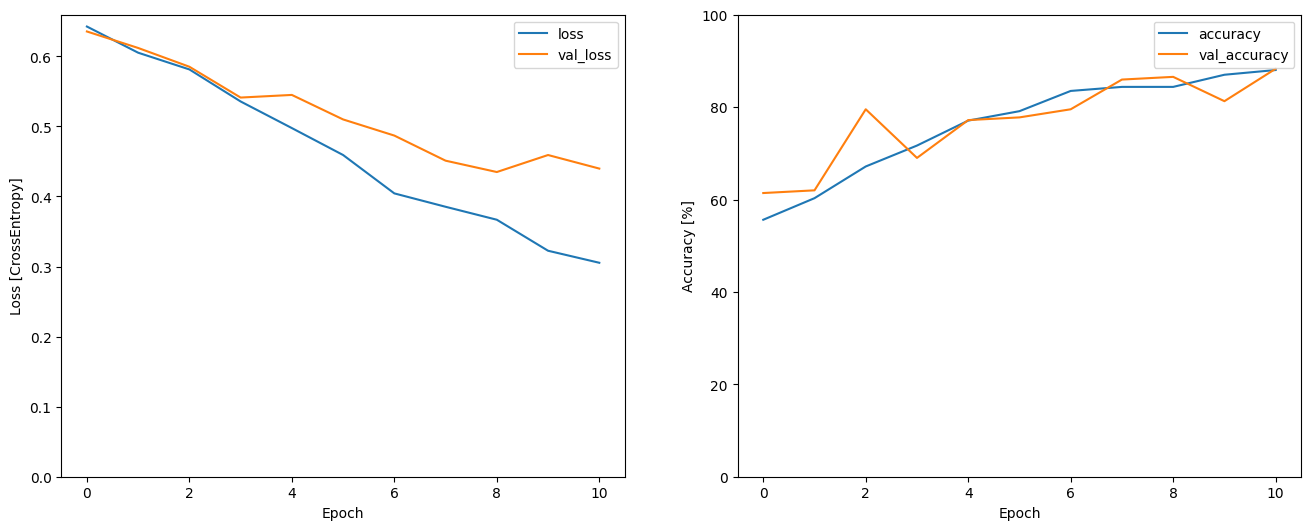

In [10]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/20
43/43 [==============================] - 1s 15ms/step - loss: 0.6730 - accuracy: 0.6117 - val_loss: 0.6675 - val_accuracy: 0.6140
Epoch 2/20
43/43 [==============================] - 0s 8ms/step - loss: 0.6499 - accuracy: 0.6190 - val_loss: 0.6614 - val_accuracy: 0.6140
Epoch 3/20
43/43 [==============================] - 0s 9ms/step - loss: 0.6449 - accuracy: 0.6190 - val_loss: 0.6583 - val_accuracy: 0.6140
Epoch 4/20
43/43 [==============================] - 0s 10ms/step - loss: 0.6429 - accuracy: 0.6190 - val_loss: 0.6608 - val_accuracy: 0.6140
Epoch 5/20
43/43 [==============================] - 0s 7ms/step - loss: 0.6399 - accuracy: 0.6190 - val_loss: 0.6649 - val_accuracy: 0.6140
Epoch 6/20
43/43 [==============================] - 0s 7ms/step - loss: 0.6353 - accuracy: 0.6190 - val_loss: 0.6425 - val_accuracy: 0.6140


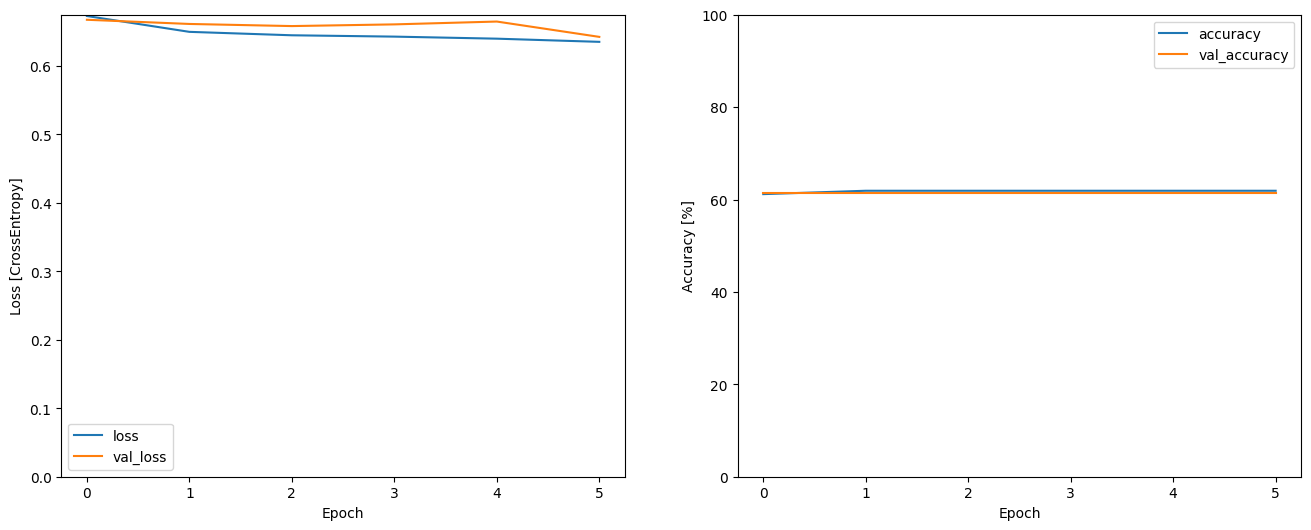

In [11]:
model_spec_conv = get_conv_model_mini(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [12]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
history_spec_conv

# Summary

In [14]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, Val. Loss: {history.history['val_loss'][-1]:.2f}, Val. Acc: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("MFCCs + Sequential model       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv model             ", history_mfcc_conv)
history_to_summary("Spectrogram + Sequential model ", history_spec_seq)
history_to_summary("Spectrogram + Conv model       ", history_spec_conv)


MFCCs + Sequential model       :    Loss: 0.29, Acc: 0.88, Val. Loss: 0.39, Val. Acc: 0.80
MFCCs + Conv model             :    Loss: 0.44, Acc: 0.81, Val. Loss: 0.45, Val. Acc: 0.80
Spectrogram + Sequential model :    Loss: 0.31, Acc: 0.88, Val. Loss: 0.44, Val. Acc: 0.88
Spectrogram + Conv model       :    Loss: 0.64, Acc: 0.62, Val. Loss: 0.64, Val. Acc: 0.61
